### Spectral Clustering

In [2]:
def create_graph(X,k_nn):
    """
    input
    X: dataset
    k_nn: number of nearest neighbors
    output
    adj_mat: adjacency matrix of the unweighted undirected graph
    """
    # make knn graph
    #1. calcukate pairwise distances
    pair_wise_dist = euclidean_distances(X)
    
   
    adj_mat = np.zeros((len(X), len(X)))
    #add edges to nearest k neighbors
    for i in range(len(X)):
        #find knearest neighbors for each point (i will go through the entore dataset)
        # sort the distances. the index of the first k values will be the nearest neighbors ofthat point
        sorted_pwd =  np.argsort((pair_wise_dist[i])) #argsort gets the index of the sorted values
        #take first k values
        knn_dp = sorted_pwd[:k_nn+1]
       
        #add edges to adjacency matrix
        for j in range(1,len(knn_dp)):
           
            if i==knn_dp[j]:
               
                adj_mat[i,knn_dp[j]] = 0
            else:
                adj_mat[i,knn_dp[j]] = 1
                adj_mat[knn_dp[j],i] = 1
            #adding a to b and b to a to make it undirected
    
   
    return adj_mat  

### Laplacian Calculation

In [3]:
def laplacian(adj_mat):
    """
    input
    nls: adjacency matrix
    output
    lap3:normlaised laplacian matrix
    
    """
    
    degree_mat = np.diag(np.sum(adj_mat, axis=1))
    
    laplacian = degree_mat - adj_mat


    #L“ = ” D−1/2(D − A)D−1/2 where D is the degree matrix of the adjacency matrix
    import copy
    
    degree_mat_sqrt = copy.copy(degree_mat)
    degree_mat_sqrt = np.zeros((len(adj_mat),len(adj_mat[0])))
    #finding 1/(D)^1/2
    for i in range(len(degree_mat)):
        degree_mat_sqrt[i,i] = 1/degree_mat[i,i]**(0.5)   
       
    #multiplying D-A and inverse matrix
    lap3 = np.matmul(np.matmul(degree_mat_sqrt, laplacian), degree_mat_sqrt)
  
    return lap3

### Calculation of Spectral Embeddings

In [4]:
from scipy.linalg import eigh
def eigen(lap3):
    """
    input
    lap3: the normalised laplacian
    outut
    Y: spectral embeddings
    """
    
    e, v = np.linalg.eig(lap3)
   
    idx = np.argsort(e)
    v = v[:, idx]
    #chosing 2 smallest vectors
    Y = v[:, 0:2]
    #v =  v.T
    #Y = v[:,0:2]
    
    return Y
 

### Calculation of Objective Function

In [5]:
def obj_fnc_calc(centroids,centroid_df):
    """
    input
    centroids: list of centroids (centroids number is 2)
    centroids_df : dataframe with cent0 and cent1 as columns. 
    cent0 has data points that belong to cluster corresponding to centroid[0]
    cent1 has data points that belong to cluster corresponding to centroid[1]
    output
    dist0+dist1:  sum of squared distances of each point from its assigned centroid
    
    """
    #data points that belong to cluster 0
    cluster0 = list(centroid_df['cent0'].dropna())
    #data point that belong to cluster 1
    cluster1 = list(centroid_df['cent1'].dropna())
    #centroid values
    centroid0 = centroids[0]
    centroid1 = centroids[1]
    dist0 = 0
    dist1 = 0
    #calculates sum of square distances of each point from its assigned cluster
    for i in range(len(cluster0)):
        dist0 += (np.linalg.norm(centroid0 - cluster0[i]))**2
    for j in range(len(cluster1)):
        dist1 += (np.linalg.norm(centroid1 - cluster1[j]))**2
        
    return dist0+dist1  

### K-Means 

In [6]:
def kmeans_fnc(data,clusters):
    """
    input: data, number of clusters
    output: centroid_df,centroids,label,obj_fnc
    centroid_df: dataframe with two columns that correspond to a cluster and the points assigned to it
    centroids: value of centroids
    label: output cluster labels
    obj_fnc: objective function result
    """
    #pick first centroid value
    centroids = data[np.random.choice(len(data), clusters, replace=False)]
    #initilaize iteration value
    k_iter = 1000

    obj_fnc = []
    for i in range(k_iter):
        #create dataframe where points will be put under cent0 or cent 1 based on their clister
        centroid_df = pd.DataFrame(columns=['cent0','cent1'])
        label = []
       
        for j in data:
            #find distance between each data point and the cluster
            cent0_dist = np.linalg.norm(centroids[0]- j )
            cent1_dist =np.linalg.norm(centroids[1]- j )
            #check distance between point and two centroids and cluster based on value
            if(cent0_dist < cent1_dist):
                centroid_df.loc[len(centroid_df)] = [j, np.nan]
                label.append(0)
            else:
                centroid_df.loc[len(centroid_df)] = [np.nan, j]
                label.append(1)
                
        # obj_fnc calc after cluster assignment
        obj_fnc.append(obj_fnc_calc(centroids,centroid_df))
        #centroid update
        # drop NaN values so the denominator when finding the mean is correct
        cent0_cluster = centroid_df['cent0'].dropna()
        cent1_cluster = centroid_df['cent1'].dropna()
        cent0_update = cent0_cluster.mean()
       
        cent1_update = cent1_cluster.mean()
        # check if updated centroid and current centroid are same. If convergence has been reachedbreak from loop
        if np.array_equal(cent0_update,centroids[0]) and np.array_equal(cent1_update,centroids[1]) :
            
            #value of obj_fnc will not change if same but incouded for uniformity
            obj_fnc.append(obj_fnc_calc(centroids,centroid_df))
            break
        else:
            #update centroid
            centroids[0] = cent0_cluster.mean()
            centroids[1] = cent1_cluster.mean()
            #objective fnc calc for centroid update
            obj_fnc.append(obj_fnc_calc(centroids,centroid_df))
       
    return centroid_df,centroids,label,obj_fnc

### Scatter Plot

In [7]:
def scatter_plot(df_fin,cen,label):
    """
    input
    df_fin: datafrae that has cluster assigments
    cen: centroids
    label: label for each data point that has been clustered
    output:
    scatter plot
    
    """
    fig, ax = plt.subplots()
    ax.scatter(df_fin['cent0'].dropna().apply(lambda x: x[0]), df_fin['cent0'].dropna().apply(lambda x: x[1]), label='Cluster 1',s=20,color = 'blue')
    ax.scatter(df_fin['cent1'].dropna().apply(lambda x: x[0]), df_fin['cent1'].dropna().apply(lambda x: x[1]), label='Cluster 2',s=20,color = 'orange')
    ax.scatter(cen[:, 0], cen[:, 1], marker='x', s=400, linewidths=10, color=['blue', 'orange'])
    plt.title("Scatter Plot with Spectral Embeddings")
    plt.xlabel("Spectral Embedding 1")
    plt.ylabel("Spectral Embedding 2")
    ax.legend()
    plt.show()
    

### Silhouette Score and NMI Score

In [8]:
def nmi_sil_score_calc(label,true_label,Y):
    """
    input
    label: cluster labels for data points
    true_label: actual cluster labels for data points
    Y: datapoints that were clustered
    """
    nmi_list = []
    sil_list = []
   
    nmi = normalized_mutual_info_score(label, true_label)
    print("NMI:", nmi)

    # Calculate the Silhouette score for the cluster labels
    silhouette = silhouette_score(Y, label)
    print("Silhouette score:", silhouette)
    return nmi,silhouette
    

### Line Plot

In [9]:
def line_plot(obj_fnc):
    """
        input
        obj_fnc: calculated obj_fns vlaues for centroid and clster updates
        output
        plot that shows the updates of the centroids and the updates of the assignments 
        as different iterations alomg the x axis and obj_fnc values along the y-axis
    """
    l = len(obj_fnc)
    l1 = obj_fnc[0::2]
    l2 = obj_fnc[1::2]
    plot_v = np.arange(l)     
    plot_v = plot_v+1
    plot_v_l1 = plot_v[0::2]
    plot_v_l2 = plot_v[1::2]
    plt.plot(plot_v,obj_fnc)
    
    a = "update cluster in iteration "
    b = "update centroid in iteration "
    res=[]
    for i in range(1,len(plot_v)//2 +1):
        res.append(a+ str(i))
        res.append(b+ str(i))
    plt.scatter(plot_v_l1,l1,color = 'green',label = 'cluster assignment')
    plt.scatter(plot_v_l2,l2,color = 'red',label = 'centroid update') 
    
    plt.xticks(plot_v, res, fontsize = 10, rotation = 90)
  
    plt.legend(loc = "upper right")
    plt.title("Objective Function of K-means Vs Iterations")
    plt.xlabel("Iterations")
    plt.ylabel("Objective function")
    plt.show()
    
    

### Main Spectral Clustering Function

In [10]:
def spectral_clustering(df,k_nn,y_data):
    """
    input
    df:dataframe that has the datapoints
    k_nn: number of k nearest neighbors to make graph
    y_data: the actual label assignment
    output
    label: label assigned by algorithm
    
    """
    # make adjacency matrix
    g = create_graph(df,k_nn)
    #calculate normalised laplacian
    L3 =laplacian(g)
    #calculate spectral embeddings
    Y = eigen(L3)
    #Kmeans clustering
    df_fin,cen,label,obj_fnc =kmeans_fnc(Y,2)
    #scatter plot for implentation correctness
    scatter_plot(df_fin,cen,label)
    #calculation of nmi and sil scores
    nmi_s,sil_s = nmi_sil_score_calc(label,y_data,Y)
    nmi_scores.append(nmi_s)
    sil_scores.append(sil_s)
    #line plot to show obj_fnv Vs centroid and cluster changes
    line_plot(obj_fnc)
    

In [ ]:
nmi_scores = []
sil_scores = []

### Implemetation with Full Dataset

C:\Users\sanja\Anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
C:\Users\sanja\Anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 569 samples in 0.001s...
[t-SNE] Computed neighbors for 569 samples in 0.009s...
[t-SNE] Computed conditional probabilities for sample 569 / 569
[t-SNE] Mean sigma: 31.918077
[t-SNE] KL divergence after 250 iterations with early exaggeration: 52.049282
[t-SNE] KL divergence after 4000 iterations: 0.249468
[[ 0.0387434  -0.05537412]
 [ 0.04417427 -0.06316037]
 [ 0.04417427 -0.0607161 ]
 ...
 [ 0.04063442 -0.04008575]
 [ 0.04063442 -0.05727033]
 [ 0.04063442  0.05957944]]


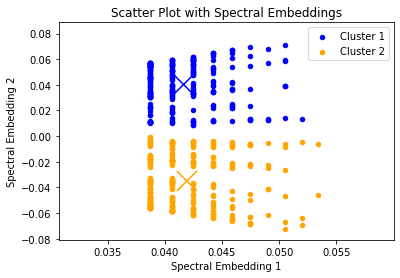

NMI: 0.40853876069480044
Silhouette score: 0.6767745777593375


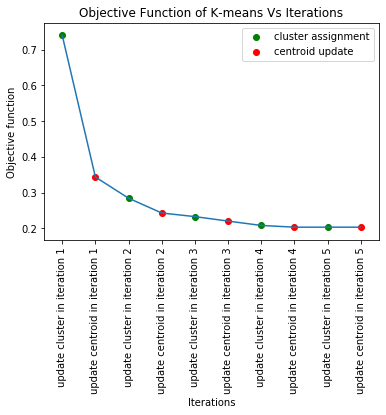

In [24]:
%matplotlib inline
from sklearn.cluster import KMeans
from sklearn.metrics import normalized_mutual_info_score, silhouette_score
from sklearn.metrics.pairwise import euclidean_distances
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.neighbors import kneighbors_graph
from sklearn.linear_model import Lasso
#Pre-processing
#df = pd.read_csv("C:/Users/sanja/Desktop/Quarter Material/Winter Quarter/DMT/data.csv")
df = pd.read_csv("data.csv")
df = df.drop('id',axis=1)
df = df.drop('Unnamed: 32',axis=1)
df = df.dropna()
#encoding
df['diagnosis'] = df['diagnosis'].map({'M':0,'B':1})
y_df = df['diagnosis']


#using columns obtained from Lasso

#LASSO feature selection
A, b = df.drop(['diagnosis'], axis=1).values, df['diagnosis'].values
# fit Lasso model
lasso = Lasso(alpha=0.1)
lasso.fit(A, b)

# print selected features
drop_features = []
for feature, coef in zip(df.drop(['diagnosis'], axis=1).columns, lasso.coef_):
    if coef == 0:
        drop_features.append(feature)
df = df.drop(columns=drop_features)

#dimentionality reduction using TSNE
from sklearn.manifold import TSNE
tsne = TSNE(verbose=1, perplexity=30, n_iter= 4000,n_components = 2)
X = tsne.fit_transform(df)
#k_nn_arr = [7,10,20,30,70]
#for i in k_nn_arr:
k=10
spectral_clustering(X,k,y_df)

### Implementation Correctness

[[ 0.         -0.25819889]
 [ 0.         -0.25819889]
 [ 0.         -0.25819889]
 [ 0.         -0.25819889]
 [ 0.         -0.25819889]
 [ 0.         -0.25819889]
 [ 0.         -0.25819889]
 [ 0.         -0.31622777]
 [ 0.         -0.25819889]
 [ 0.         -0.25819889]
 [ 0.         -0.25819889]
 [ 0.         -0.31622777]
 [ 0.         -0.25819889]
 [ 0.         -0.25819889]
 [-0.57735027  0.        ]
 [-0.57735027  0.        ]
 [-0.57735027  0.        ]]


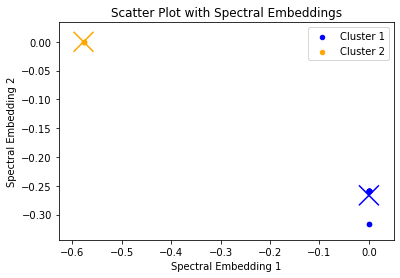

NMI: 1.0
Silhouette score: 0.9804629238540817


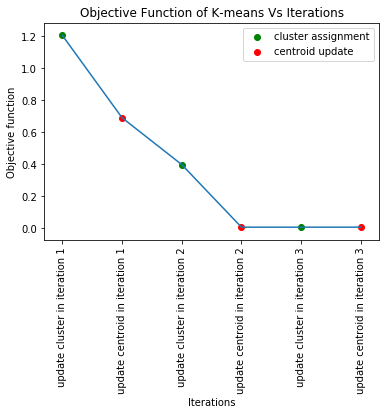

In [12]:
%matplotlib inline
from sklearn.cluster import KMeans
from sklearn.metrics import normalized_mutual_info_score, silhouette_score
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics.pairwise import euclidean_distances
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.neighbors import kneighbors_graph
#data = pd.read_csv("C:/Users/sanja/Desktop/Quarter Material/Winter Quarter/DMT/DMT-FINAL/implementation_correctness_dataset.csv")
data = pd.read_csv("implementation_correctness_dataset.csv")
y_data = data['Class/Cluster']

data = data.drop('Class/Cluster',axis = 1)

spectral_clustering(data,2,y_data)

### Plot Generation

### Silhouette, NMI for different KNN values

In [14]:
#for error bar
std_sil_score = np.std(sil_scores)
std_nmi_score = np.std(nmi_scores)

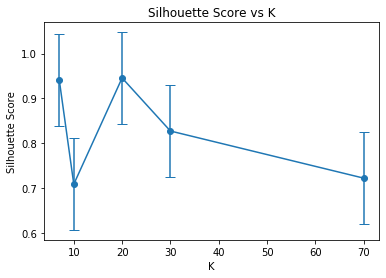

In [28]:
k_nn_arr = [7,10,20,30,70]
plt.errorbar(k_nn_arr, sil_scores, yerr=std_sil_score, fmt='o-', capsize=5)

# set axis labels and title
plt.xlabel('K')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs K')

# display plot
plt.show()

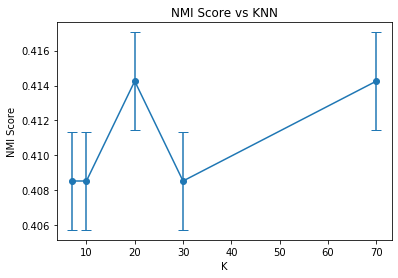

In [29]:
plt.errorbar(k_nn_arr, nmi_scores, yerr=std_nmi_score, fmt='o-', capsize=5)

# set axis labels and title
plt.xlabel('K')
plt.ylabel('NMI Score')
plt.title('NMI Score vs KNN')

# display plot
plt.show()

### Silhouette Score and NMI Score for different K-folds

[[-0.04499213  0.07110331]
 [-0.05510388  0.08777672]
 [-0.0532354   0.07897953]
 [-0.04499213 -0.03780479]
 [-0.04499213  0.0651728 ]
 [-0.04718814 -0.00160908]
 [-0.05129892  0.0709202 ]
 [-0.04928641  0.01245005]
 [-0.04499213 -0.00088989]
 [-0.04499213 -0.00418498]
 [-0.04718814  0.03546297]
 [-0.04499213  0.03964332]
 [-0.04499213  0.05191112]
 [-0.04718814  0.02041197]
 [-0.05866256 -0.00064788]
 [-0.04928641  0.0223756 ]
 [-0.04499213  0.02801215]
 [-0.04718814  0.04234353]
 [-0.0532354   0.08565429]
 [-0.05691104  0.00024706]
 [-0.05510388 -0.01970743]
 [-0.04718814 -0.07044187]
 [-0.05866256  0.03012288]
 [-0.0532354   0.08606663]
 [-0.04499213  0.07170107]
 [-0.04499213  0.05214138]
 [-0.04928641  0.01639311]
 [-0.04499213  0.05479621]
 [-0.04499213  0.03829835]
 [-0.04928641  0.05096362]
 [-0.04718814  0.06635686]
 [-0.04499213  0.00757993]
 [-0.04718814  0.05069486]
 [-0.04928641  0.07577624]
 [-0.04928641  0.04294339]
 [-0.05510388  0.04988967]
 [-0.05129892  0.01145771]
 

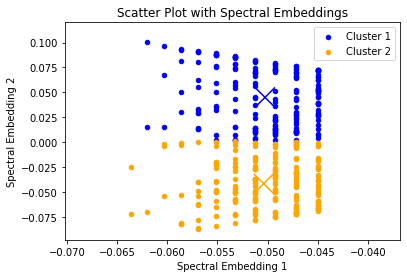

NMI: 0.493918899756446
Silhouette score: 0.5974076595376118


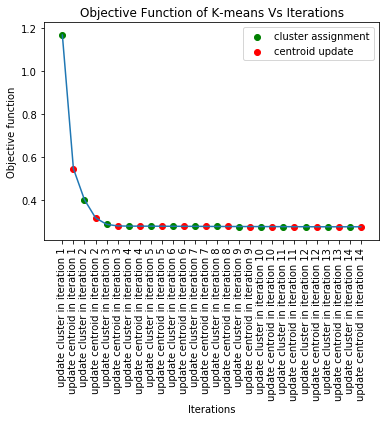

[[-0.04703604  0.0726795 ]
 [-0.05362934  0.0833569 ]
 [-0.05362934  0.07822236]
 [-0.04703604 -0.0398088 ]
 [-0.04703604  0.06617148]
 [-0.04933182 -0.00222364]
 [-0.05362934  0.07309132]
 [-0.0515254   0.01219354]
 [-0.04703604 -0.00152513]
 [-0.04703604 -0.00477448]
 [-0.0515254   0.03960339]
 [-0.04703604  0.04210709]
 [-0.04703604  0.05462012]
 [-0.04703604  0.02218828]
 [-0.0613275  -0.00124777]
 [-0.0515254   0.02426671]
 [-0.04703604  0.03036644]
 [-0.04933182  0.04489455]
 [-0.05362934  0.08419022]
 [-0.0613275  -0.00059426]
 [-0.05760715 -0.01943465]
 [-0.04933182 -0.07616856]
 [-0.0613275   0.03301071]
 [-0.05362934  0.08449071]
 [-0.04703604  0.07323489]
 [-0.04703604  0.05418279]
 [-0.0515254   0.01661778]
 [-0.04703604  0.05765588]
 [-0.04703604  0.04082872]
 [-0.0515254   0.05305996]
 [-0.04933182  0.06833428]
 [-0.04703604  0.00723919]
 [-0.04933182  0.05287357]
 [-0.0556538   0.08373112]
 [-0.04933182  0.04393717]
 [-0.05760715  0.05251255]
 [-0.0556538   0.01025378]
 

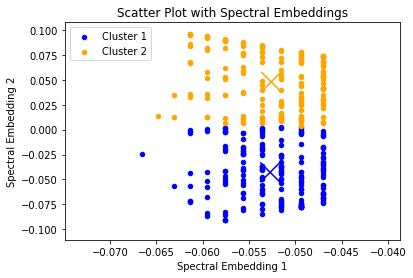

NMI: 0.5210200223844461
Silhouette score: 0.593269238860405


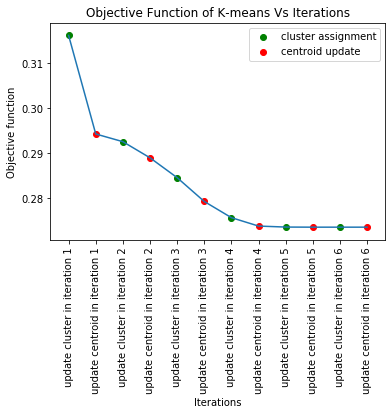

[[-0.04078407  0.06469875]
 [-0.04825636  0.07707601]
 [-0.04650099  0.06973144]
 [-0.04078407 -0.03552252]
 [-0.04078407  0.05930028]
 [-0.04277469  0.00226799]
 [-0.04825636  0.06881818]
 [-0.04467671  0.01578992]
 [-0.04277469  0.00323979]
 [-0.04078407 -0.00125899]
 [-0.04277469  0.03538267]
 [-0.04078407  0.03932899]
 [-0.04078407  0.05116351]
 [-0.04277469  0.02255047]
 [-0.04825636  0.00353477]
 [-0.04467671  0.02336723]
 [-0.04078407  0.02841847]
 [-0.04277469  0.04193453]
 [-0.04825636  0.07798014]
 [-0.05471757  0.00476907]
 [-0.05471757 -0.02068497]
 [-0.04277469 -0.06214301]
 [-0.04995007  0.02962022]
 [-0.04995007  0.08108783]
 [-0.04078407  0.06523417]
 [-0.04277469  0.05319999]
 [-0.04825636  0.02042168]
 [-0.04277469  0.0555003 ]
 [-0.04078407  0.03843257]
 [-0.04650099  0.05203628]
 [-0.04825636  0.06961876]
 [-0.04078407  0.01077358]
 [-0.04650099  0.0537338 ]
 [-0.04467671  0.06910866]
 [-0.04650099  0.04448205]
 [-0.04277469  0.04214967]
 [-0.04825636  0.01489805]
 

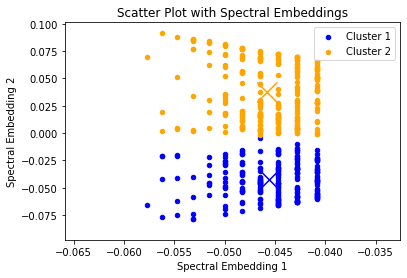

NMI: 0.43690551764032265
Silhouette score: 0.6455154626940789


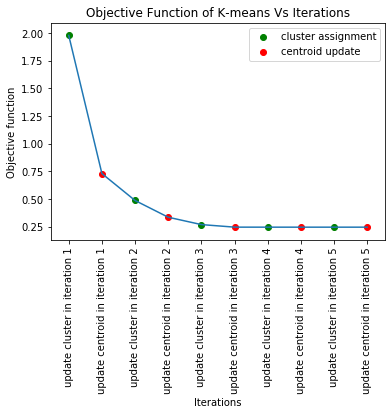

[[-4.87833899e-02  7.53433984e-02]
 [-5.56216224e-02  8.63206368e-02]
 [-5.56216224e-02  8.01281065e-02]
 [-4.87833899e-02 -4.20973717e-02]
 [-4.87833899e-02  6.81206533e-02]
 [-5.11644510e-02 -3.74200836e-03]
 [-5.56216224e-02  7.42064104e-02]
 [-5.34395262e-02  1.14242494e-02]
 [-4.87833899e-02 -2.93855984e-03]
 [-4.87833899e-02 -6.38713121e-03]
 [-5.34395262e-02  3.98579262e-02]
 [-4.87833899e-02  4.28816964e-02]
 [-4.87833899e-02  5.51111659e-02]
 [-4.87833899e-02  1.97843962e-02]
 [-6.36057586e-02 -3.42086831e-03]
 [-5.77212854e-02  2.54045479e-02]
 [-4.87833899e-02  3.01469135e-02]
 [-5.34395262e-02  4.84288419e-02]
 [-5.77212854e-02  9.04511694e-02]
 [-6.36057586e-02 -2.53808018e-03]
 [-5.97472066e-02 -2.22440893e-02]
 [-5.11644510e-02 -8.13745634e-02]
 [-5.97472066e-02  3.05747496e-02]
 [-5.56216224e-02  8.73100679e-02]
 [-4.87833899e-02  7.58476830e-02]
 [-4.87833899e-02  5.46754458e-02]
 [-5.34395262e-02  1.67157737e-02]
 [-5.11644510e-02  6.08232860e-02]
 [-4.87833899e-02  4

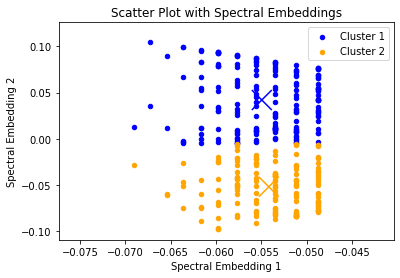

NMI: 0.48969000519209516
Silhouette score: 0.5942672536639644


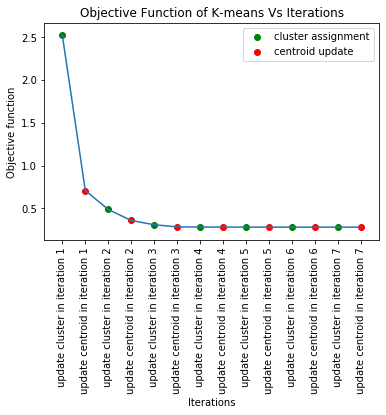

[[ 0.05354412+0.j -0.07704636+0.j]
 [ 0.06335425+0.j -0.09088216+0.j]
 [ 0.06104969+0.j -0.08196028+0.j]
 [ 0.05354412+0.j  0.04917444+0.j]
 [ 0.05354412+0.j -0.0704933 +0.j]
 [ 0.05615754+0.j  0.00724287+0.j]
 [ 0.05615754+0.j -0.07131764+0.j]
 [ 0.05865464+0.j -0.00894045+0.j]
 [ 0.05354412+0.j  0.00670424+0.j]
 [ 0.05354412+0.j  0.01208967+0.j]
 [ 0.05865464+0.j -0.04156099+0.j]
 [ 0.05354412+0.j -0.04337866+0.j]
 [ 0.05354412+0.j -0.05590419+0.j]
 [ 0.05354412+0.j -0.01898139+0.j]
 [ 0.06557788+0.j  0.00706062+0.j]
 [ 0.06335425+0.j -0.02351979+0.j]
 [ 0.05354412+0.j -0.0297602 +0.j]
 [ 0.06104969+0.j -0.05147715+0.j]
 [ 0.06335425+0.j -0.09242395+0.j]
 [ 0.06772855+0.j  0.00669145+0.j]
 [ 0.06772855+0.j  0.03123539+0.j]
 [ 0.06335425+0.j  0.10645384+0.j]
 [ 0.06557788+0.j -0.02886411+0.j]
 [ 0.06104969+0.j -0.089248  +0.j]
 [ 0.05354412+0.j -0.0774038 +0.j]
 [ 0.05354412+0.j -0.05538691+0.j]
 [ 0.05865464+0.j -0.0143175 +0.j]
 [ 0.05615754+0.j -0.06098536+0.j]
 [ 0.05354412+0.j -0

C:\Users\sanja\Anaconda3\lib\site-packages\matplotlib\collections.py:151: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)


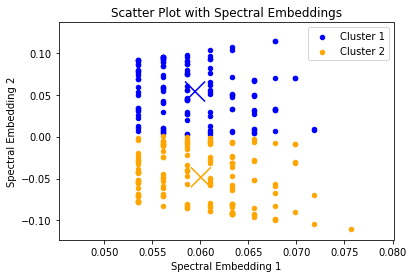

NMI: 0.5064771608793691


ValueError: Complex data not supported
[[ 0.05354412+0.j -0.07704636+0.j]
 [ 0.06335425+0.j -0.09088216+0.j]
 [ 0.06104969+0.j -0.08196028+0.j]
 [ 0.05354412+0.j  0.04917444+0.j]
 [ 0.05354412+0.j -0.0704933 +0.j]
 [ 0.05615754+0.j  0.00724287+0.j]
 [ 0.05615754+0.j -0.07131764+0.j]
 [ 0.05865464+0.j -0.00894045+0.j]
 [ 0.05354412+0.j  0.00670424+0.j]
 [ 0.05354412+0.j  0.01208967+0.j]
 [ 0.05865464+0.j -0.04156099+0.j]
 [ 0.05354412+0.j -0.04337866+0.j]
 [ 0.05354412+0.j -0.05590419+0.j]
 [ 0.05354412+0.j -0.01898139+0.j]
 [ 0.06557788+0.j  0.00706062+0.j]
 [ 0.06335425+0.j -0.02351979+0.j]
 [ 0.05354412+0.j -0.0297602 +0.j]
 [ 0.06104969+0.j -0.05147715+0.j]
 [ 0.06335425+0.j -0.09242395+0.j]
 [ 0.06772855+0.j  0.00669145+0.j]
 [ 0.06772855+0.j  0.03123539+0.j]
 [ 0.06335425+0.j  0.10645384+0.j]
 [ 0.06557788+0.j -0.02886411+0.j]
 [ 0.06104969+0.j -0.089248  +0.j]
 [ 0.05354412+0.j -0.0774038 +0.j]
 [ 0.05354412+0.j -0.05538691+0.j]
 [ 0.05865464+0.j -0.0143175 +0.j]
 [ 0.05615754+0.j -0.06098536+0.j]
 [ 0.05354412+0.j -0.04200654+0.j]
 [ 0.06104969+0.j -0.05512163+0.j]
 [ 0.06104969+0.j -0.07871868+0.j]
 [ 0.05354412+0.j -0.00396178+0.j]
 [ 0.05615754+0.j -0.05264501+0.j]
 [ 0.05865464+0.j -0.08183976+0.j]
 [ 0.05865464+0.j -0.04675433+0.j]
 [ 0.06772855+0.j -0.05610306+0.j]
 [ 0.06557788+0.j -0.00617685+0.j]
 [ 0.05354412+0.j  0.03433985+0.j]
 [ 0.05354412+0.j -0.00212557+0.j]
 [ 0.06104969+0.j  0.00536359+0.j]
 [ 0.06557788+0.j -0.00235803+0.j]
 [ 0.05615754+0.j  0.05893263+0.j]
 [ 0.06981299+0.j -0.08993664+0.j]
 [ 0.05615754+0.j -0.00838697+0.j]
 [ 0.06335425+0.j  0.00692238+0.j]
 [ 0.06335425+0.j -0.0799176 +0.j]
 [ 0.05354412+0.j  0.09080421+0.j]
 [ 0.05865464+0.j  0.00337316+0.j]
 [ 0.05615754+0.j  0.04130507+0.j]
 [ 0.06557788+0.j  0.00850996+0.j]
 [ 0.06557788+0.j  0.06594657+0.j]
 [ 0.05615754+0.j  0.01045631+0.j]
 [ 0.05865464+0.j  0.0555702 +0.j]
 [ 0.06335425+0.j -0.06393745+0.j]
 [ 0.06335425+0.j -0.03129521+0.j]
 [ 0.06557788+0.j  0.0680565 +0.j]
 [ 0.06335425+0.j -0.09188521+0.j]
 [ 0.06557788+0.j -0.02848793+0.j]
 [ 0.06557788+0.j  0.03106818+0.j]
 [ 0.05615754+0.j  0.09517881+0.j]
 [ 0.05615754+0.j  0.08951766+0.j]
 [ 0.05615754+0.j  0.09517881+0.j]
 [ 0.05865464+0.j -0.02233925+0.j]
 [ 0.06772855+0.j  0.1141892 +0.j]
 [ 0.05615754+0.j -0.00741116+0.j]
 [ 0.06335425+0.j -0.02403483+0.j]
 [ 0.05615754+0.j  0.09343813+0.j]
 [ 0.05865464+0.j  0.07411276+0.j]
 [ 0.06772855+0.j  0.11396167+0.j]
 [ 0.05615754+0.j  0.03994216+0.j]
 [ 0.05865464+0.j -0.08287382+0.j]
 [ 0.06104969+0.j  0.1032719 +0.j]
 [ 0.05354412+0.j -0.06803767+0.j]
 [ 0.06104969+0.j -0.00629648+0.j]
 [ 0.05354412+0.j  0.03375851+0.j]
 [ 0.06557788+0.j -0.05208994+0.j]
 [ 0.05354412+0.j  0.02540054+0.j]
 [ 0.05615754+0.j -0.07026252+0.j]
 [ 0.05354412+0.j -0.0704933 +0.j]
 [ 0.06772855+0.j  0.03256571+0.j]
 [ 0.06104969+0.j  0.06139264+0.j]
 [ 0.06557788+0.j  0.0315085 +0.j]
 [ 0.06104969+0.j -0.08922896+0.j]
 [ 0.05354412+0.j -0.05450571+0.j]
 [ 0.06335425+0.j  0.05107166+0.j]
 [ 0.06335425+0.j -0.08067564+0.j]
 [ 0.06981299+0.j -0.00825391+0.j]
 [ 0.06335425+0.j -0.08115333+0.j]
 [ 0.06557788+0.j  0.04790839+0.j]
 [ 0.06772855+0.j -0.00813732+0.j]
 [ 0.06335425+0.j -0.00793204+0.j]
 [ 0.05615754+0.j -0.0098    +0.j]
 [ 0.06104969+0.j -0.00611269+0.j]
 [ 0.07183697+0.j  0.00914604+0.j]
 [ 0.06335425+0.j -0.03129521+0.j]
 [ 0.06104969+0.j -0.08387334+0.j]
 [ 0.05354412+0.j  0.05349708+0.j]
 [ 0.05615754+0.j  0.09130323+0.j]
 [ 0.06772855+0.j  0.06935055+0.j]
 [ 0.06104969+0.j -0.00847942+0.j]
 [ 0.05865464+0.j -0.01152433+0.j]
 [ 0.05354412+0.j  0.09080421+0.j]
 [ 0.06335425+0.j  0.04907187+0.j]
 [ 0.05865464+0.j  0.09500838+0.j]
 [ 0.06104969+0.j  0.09281519+0.j]
 [ 0.05865464+0.j -0.00453519+0.j]
 [ 0.06981299+0.j  0.06938687+0.j]
 [ 0.05865464+0.j  0.04411093+0.j]
 [ 0.06557788+0.j -0.09578225+0.j]
 [ 0.05615754+0.j  0.05776612+0.j]
 [ 0.05354412+0.j  0.08685328+0.j]
 [ 0.05615754+0.j  0.04232682+0.j]
 [ 0.05615754+0.j  0.00131077+0.j]
 [ 0.05865464+0.j  0.09057272+0.j]
 [ 0.05615754+0.j  0.09517881+0.j]
 [ 0.05865464+0.j  0.04511066+0.j]
 [ 0.05615754+0.j  0.09513739+0.j]
 [ 0.05354412+0.j -0.02849339+0.j]
 [ 0.05354412+0.j -0.04272741+0.j]
 [ 0.06104969+0.j -0.05755998+0.j]
 [ 0.05865464+0.j  0.06080423+0.j]
 [ 0.06772855+0.j -0.08284814+0.j]
 [ 0.05865464+0.j -0.08530485+0.j]
 [ 0.05865464+0.j -0.00097711+0.j]
 [ 0.05354412+0.j  0.02220654+0.j]
 [ 0.06557788+0.j  0.0041337 +0.j]
 [ 0.06104969+0.j -0.00743031+0.j]
 [ 0.06335425+0.j -0.07979306+0.j]
 [ 0.05615754+0.j -0.0057799 +0.j]
 [ 0.06557788+0.j -0.08497646+0.j]
 [ 0.06335425+0.j  0.04982642+0.j]
 [ 0.05865464+0.j -0.03991565+0.j]
 [ 0.06335425+0.j -0.04684331+0.j]
 [ 0.05615754+0.j -0.02388033+0.j]
 [ 0.06335425+0.j -0.08067564+0.j]
 [ 0.06104969+0.j  0.02437947+0.j]
 [ 0.06104969+0.j  0.05569929+0.j]
 [ 0.05865464+0.j  0.07411276+0.j]
 [ 0.05354412+0.j -0.0230018 +0.j]
 [ 0.05865464+0.j  0.07927455+0.j]
 [ 0.05865464+0.j  0.09697793+0.j]
 [ 0.06557788+0.j -0.05208994+0.j]
 [ 0.06104969+0.j  0.06530733+0.j]
 [ 0.05865464+0.j  0.02679024+0.j]
 [ 0.05354412+0.j  0.07543634+0.j]
 [ 0.05615754+0.j  0.05704112+0.j]
 [ 0.05865464+0.j  0.04585324+0.j]
 [ 0.05615754+0.j -0.00828892+0.j]
 [ 0.06104969+0.j -0.00466253+0.j]
 [ 0.06557788+0.j  0.00452104+0.j]
 [ 0.06772855+0.j  0.03211663+0.j]
 [ 0.05354412+0.j  0.09080421+0.j]
 [ 0.05354412+0.j  0.0850452 +0.j]
 [ 0.06104969+0.j  0.08132538+0.j]
 [ 0.06104969+0.j  0.01276468+0.j]
 [ 0.06557788+0.j  0.04930994+0.j]
 [ 0.07183697+0.j -0.06999421+0.j]
 [ 0.05354412+0.j -0.03252288+0.j]
 [ 0.06104969+0.j  0.05077917+0.j]
 [ 0.05615754+0.j  0.07308311+0.j]
 [ 0.05865464+0.j  0.05506786+0.j]
 [ 0.05615754+0.j -0.06905282+0.j]
 [ 0.07183697+0.j -0.1044097 +0.j]
 [ 0.06557788+0.j  0.05013646+0.j]
 [ 0.06335425+0.j -0.0925749 +0.j]
 [ 0.05865464+0.j -0.00671185+0.j]
 [ 0.05354412+0.j  0.07814712+0.j]
 [ 0.06772855+0.j -0.05912296+0.j]
 [ 0.05354412+0.j -0.06803767+0.j]
 [ 0.05865464+0.j -0.00671185+0.j]
 [ 0.06335425+0.j  0.04781666+0.j]
 [ 0.05615754+0.j -0.01746678+0.j]
 [ 0.05865464+0.j -0.03367354+0.j]
 [ 0.05354412+0.j  0.07880692+0.j]
 [ 0.05615754+0.j  0.08397462+0.j]
 [ 0.05615754+0.j  0.09517881+0.j]
 [ 0.06104969+0.j  0.0959415 +0.j]
 [ 0.05354412+0.j -0.02685459+0.j]
 [ 0.06772855+0.j  0.03287751+0.j]
 [ 0.05354412+0.j  0.03158935+0.j]
 [ 0.05354412+0.j -0.07836678+0.j]
 [ 0.07572282+0.j -0.10980836+0.j]
 [ 0.05615754+0.j -0.04426953+0.j]
 [ 0.05865464+0.j  0.07411276+0.j]
 [ 0.06981299+0.j -0.03064064+0.j]
 [ 0.05354412+0.j  0.07985284+0.j]
 [ 0.05615754+0.j -0.05869129+0.j]
 [ 0.06981299+0.j  0.06967665+0.j]
 [ 0.05615754+0.j  0.05858703+0.j]
 [ 0.05865464+0.j  0.0448558 +0.j]
 [ 0.06104969+0.j -0.00133971+0.j]
 [ 0.05354412+0.j  0.03017909+0.j]
 [ 0.05354412+0.j  0.08962165+0.j]
 [ 0.05615754+0.j  0.005498  +0.j]
 [ 0.06335425+0.j -0.00694134+0.j]
 [ 0.06335425+0.j  0.03287825+0.j]
 [ 0.05615754+0.j -0.00479934+0.j]
 [ 0.05865464+0.j -0.05618689+0.j]
 [ 0.06335425+0.j -0.0841722 +0.j]
 [ 0.06104969+0.j -0.02817694+0.j]
 [ 0.05615754+0.j  0.02946069+0.j]
 [ 0.06335425+0.j -0.05779861+0.j]
 [ 0.05865464+0.j -0.0847588 +0.j]
 [ 0.05354412+0.j -0.02746217+0.j]
 [ 0.05865464+0.j  0.0201095 +0.j]
 [ 0.06981299+0.j -0.03133093+0.j]
 [ 0.05615754+0.j  0.09311223+0.j]
 [ 0.05615754+0.j -0.04783551+0.j]
 [ 0.06557788+0.j  0.02692282+0.j]
 [ 0.05615754+0.j -0.02399164+0.j]
 [ 0.05354412+0.j -0.07139905+0.j]
 [ 0.06104969+0.j  0.05373251+0.j]
 [ 0.05354412+0.j -0.07822055+0.j]
 [ 0.05354412+0.j -0.03875415+0.j]
 [ 0.06335425+0.j -0.00643006+0.j]
 [ 0.05865464+0.j  0.00314522+0.j]
 [ 0.05615754+0.j  0.05395023+0.j]
 [ 0.05865464+0.j  0.08998794+0.j]
 [ 0.06772855+0.j -0.09780526+0.j]
 [ 0.06335425+0.j -0.09248924+0.j]
 [ 0.07183697+0.j  0.0081668 +0.j]
 [ 0.05615754+0.j  0.00771962+0.j]
 [ 0.05615754+0.j  0.08889389+0.j]
 [ 0.06335425+0.j -0.03682912+0.j]
 [ 0.06557788+0.j  0.00862917+0.j]
 [ 0.05615754+0.j -0.0106136 +0.j]
 [ 0.06104969+0.j  0.0928402 +0.j]
 [ 0.05615754+0.j -0.00828892+0.j]
 [ 0.06104969+0.j  0.02931813+0.j]
 [ 0.05615754+0.j  0.01036907+0.j]
 [ 0.06104969+0.j -0.04943499+0.j]
 [ 0.05354412+0.j  0.06906681+0.j]
 [ 0.05615754+0.j  0.0705239 +0.j]
 [ 0.06335425+0.j -0.09047775+0.j]
 [ 0.05615754+0.j  0.09311223+0.j]
 [ 0.06104969+0.j  0.00344537+0.j]
 [ 0.05615754+0.j -0.0821786 +0.j]
 [ 0.05865464+0.j -0.0804446 +0.j]
 [ 0.06104969+0.j -0.00224804+0.j]
 [ 0.05354412+0.j -0.05168935+0.j]
 [ 0.06104969+0.j  0.00774686+0.j]
 [ 0.05865464+0.j  0.04347546+0.j]
 [ 0.06104969+0.j  0.07612068+0.j]
 [ 0.06335425+0.j  0.00515776+0.j]
 [ 0.05354412+0.j -0.06154612+0.j]
 [ 0.05615754+0.j  0.08473725+0.j]
 [ 0.05865464+0.j  0.0291104 +0.j]
 [ 0.05865464+0.j  0.02679024+0.j]
 [ 0.05354412+0.j  0.07323153+0.j]
 [ 0.06335425+0.j  0.07129633+0.j]
 [ 0.06772855+0.j -0.09808196+0.j]
 [ 0.06557788+0.j  0.06780901+0.j]
 [ 0.06335425+0.j -0.09108517+0.j]
 [ 0.05615754+0.j -0.04932417+0.j]
 [ 0.06335425+0.j -0.09108517+0.j]
 [ 0.06981299+0.j -0.00888772+0.j]
 [ 0.06557788+0.j -0.09403147+0.j]
 [ 0.06104969+0.j -0.02477212+0.j]
 [ 0.05354412+0.j -0.04200654+0.j]
 [ 0.06104969+0.j -0.03102151+0.j]
 [ 0.06557788+0.j -0.09281694+0.j]
 [ 0.06104969+0.j -0.05443742+0.j]
 [ 0.06335425+0.j -0.06007557+0.j]
 [ 0.06335425+0.j -0.03106236+0.j]
 [ 0.05354412+0.j -0.05272815+0.j]
 [ 0.05354412+0.j -0.07835239+0.j]
 [ 0.05865464+0.j  0.08627422+0.j]
 [ 0.05354412+0.j  0.0105333 +0.j]
 [ 0.06335425+0.j  0.03287825+0.j]
 [ 0.05865464+0.j  0.08714488+0.j]
 [ 0.05615754+0.j  0.00394516+0.j]
 [ 0.05865464+0.j  0.07657106+0.j]
 [ 0.06772855+0.j -0.09889402+0.j]
 [ 0.06335425+0.j  0.10371801+0.j]
 [ 0.06772855+0.j -0.06671059+0.j]
 [ 0.05354412+0.j  0.05929088+0.j]
 [ 0.05354412+0.j  0.06906681+0.j]
 [ 0.05354412+0.j -0.05170845+0.j]]


In [21]:
import random

n_samples = df.shape[0]
n_subsets = 6
subset_size = 1

# Initialize lists for storing scores
subset_scores = []

# Loop through subsets and calculate scores
for i in range(n_subsets):
    # Select a random subset of data
    subset_indices = random.randint(80, 569)
    subset_X = df[:subset_indices]
    y_df = df['diagnosis'][:subset_indices]
    spectral_clustering(subset_X,10,y_df)
    
    

[0.6152706632455412, 0.5869237237391858, 0.5869237237391858, 0.6101094005948214, 0.6137756066185094, 0.6068260466821725]


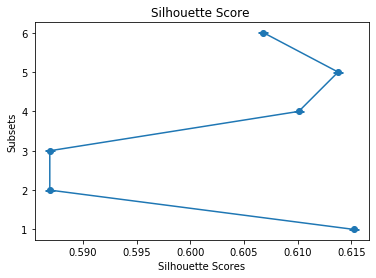

In [18]:

subset_no = [1,2,3,4,5,6]
plt.errorbar(sil_scores ,subset_no,yerr= std_sil_score,fmt='o-', capsize=5)

# set axis labels and title
plt.xlabel('Silhouette Scores')
plt.ylabel('Subsets')
plt.title('Silhouette Score ')

# display plot
plt.show()

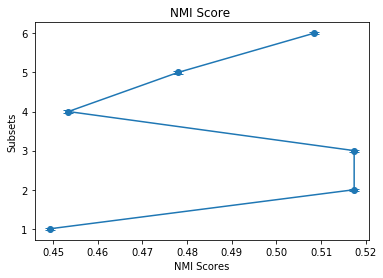

In [19]:
plt.errorbar(nmi_scores ,y,yerr= std_nmi_score,fmt='o-', capsize=5)

# set axis labels and title
plt.xlabel('NMI Scores')
plt.ylabel('Subsets')
plt.title('NMI Score ')

# display plot
plt.show()